## Explore Exercise: NLP Unit
### Corey Solitaire
`11.17.2020`

#### Imports:

In [1]:
import re
import unicodedata
import pandas as pd
import nltk

import prepare
import acquire

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Sanity Check prepare and acquire files

In [2]:
# Test Acquire
urls = []
df = acquire.get_blog_articles(urls, cached=True)
df.head()

,title,content
0,Codeup’s Data Science Career Accelerator is Here!,The rumors are true! The time has arrived. Cod...
1,Data Science Myths,By Dimitri Antoniou and Maggie Giust\nData Sci...
2,Data Science VS Data Analytics: What’s The Dif...,"By Dimitri Antoniou\nA week ago, Codeup launch..."
3,10 Tips to Crush It at the SA Tech Job Fair,SA Tech Job Fair\nThe third bi-annual San Anto...
4,Competitor Bootcamps Are Closing. Is the Model...,Competitor Bootcamps Are Closing. Is the Model...


In [3]:
# Test Prepare
df = prepare.prep_article_data(df, 'content')
df

,title,content,stemmed,lemmatized,clean
0,Codeup’s Data Science Career Accelerator is Here!,The rumors are true! The time has arrived. Cod...,he rumor are true he time ha arriv odeup ha of...,he rumor are true he time ha arrived odeup ha ...,rumor true time arrived odeup officially opene...
1,Data Science Myths,By Dimitri Antoniou and Maggie Giust\nData Sci...,y imitri ntoniou and aggi iust ata cienc ig at...,y imitri ntoniou and aggie iust ata cience ig ...,imitri ntoniou aggie iust ata cience ig ata ac...
2,Data Science VS Data Analytics: What’s The Dif...,"By Dimitri Antoniou\nA week ago, Codeup launch...",y imitri ntoniou week ago odeup launch our imm...,y imitri ntoniou week ago odeup launched our i...,imitri ntoniou week ago odeup launched immersi...
3,10 Tips to Crush It at the SA Tech Job Fair,SA Tech Job Fair\nThe third bi-annual San Anto...,ech ob air he third biannual an ntonio ech ob ...,ech ob air he third biannual an ntonio ech ob ...,ech ob air third biannual ntonio ech ob air ar...
4,Competitor Bootcamps Are Closing. Is the Model...,Competitor Bootcamps Are Closing. Is the Model...,ompetitor ootcamp re lose s the odel in anger ...,ompetitor ootcamps re losing s the odel in ang...,ompetitor ootcamps losing odel anger programmi...


#### Load text dataset:

In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [5]:
# Special Formatting to read in this data frame
df = pd.read_csv('spam.csv', encoding='latin-1', usecols=[0,1])
df.columns = ['label', 'text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Clean Data:

In [6]:
# Define Functions

def basic_clean(text):
    text = (unicodedata.normalize('NFKD', text.lower())
            .encode('ascii', 'ignore') # ascii to reduce noise
            .decode('utf-8', 'ignore') # decode using utf-8
           )
    return re.sub(r"[^a-z0-9\s]", '', text)

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()
    
    # Use tokenizer
    string = tokenizer.tokenize(string, return_str=True)
    
    return string

def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string



def remove_stopwords(string, extra_words=[], exclude_words=[]):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')
    
    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)
    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))
    
    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords

In [7]:
# Apply Functions

df['text_cleaned'] = df.text.apply(basic_clean)
df['text_tokenized'] = df.text_cleaned.apply(tokenize)
df['text_lemmatized'] = df.text_tokenized.apply(lemmatize)
df['text_filtered'] = df.text_lemmatized.apply(remove_stopwords)
# Add column with list of words
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
# Adds colum with lenght of word list
df['doc_length'] = [len(wordlist) for wordlist in df.words]
df.head()

,label,text,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,doc_length
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go until jurong point crazy available only in ...,go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugisgre...",12
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,ok lar joking wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wifoni]",4
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[free, entrywkly, comp, win, fa, cup, final, t...",21
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say so early hor u c already then say,u dun say so early hor u c already then say,u dun say early hor u c already say,"[u, dun, say, early, horc, already, say]",7
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah i dont think he goes to usf he lives aroun...,nah i dont think he go to usf he life around h...,nah dont think go usf life around though,"[nah, dont, think, go, usf, life, around, though]",8


## Exercises:

### 1. Spam Data


#### -a. Load the spam data set.
        

In [8]:
# Creates text list off categorized words

ham_words = ' '.join(df[df.label=='ham'].text_filtered)
spam_words = ' '.join(df[df.label=='spam'].text_filtered)
all_words = ' '.join(df.text_filtered)

all_words

'go jurong point crazy available bugis n great world la e buffet cine got amore wat ok lar joking wif u oni free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s u dun say early hor u c already say nah dont think go usf life around though freemsg hey darling 3 week word back id like fun still tb ok xxx std chgs send a150 rcv even brother like speak treat like aid patent per request melle melle oru minnaminunginte nurungu vettam ha set callertune caller press 9 copy friend callertune winner valued network customer selected receivea a900 prize reward claim call 09061701461 claim code kl341 valid 12 hour mobile 11 month u r entitled update latest colour mobile camera free call mobile update co free 08002986030 im gonna home soon dont want talk stuff anymore tonight k ive cried enough today six chance win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6days 16 tsandcs apply reply hl 4 info urgent 1 we

In [9]:
# Remove single Characters

ham_words = re.sub(r'\s.\s', '', ham_words)
spam_words = re.sub(r'\s.\s', '', spam_words)
all_words = re.sub(r'\s.\s', '', all_words)

all_words

'go jurong point crazy available bugisgreat world labuffet cine got amore wat ok lar joking wifoni free entrywkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18sdun say early horc already say nah dont think go usf life around though freemsg hey darlingweek word back id like fun still tb ok xxx std chgs send a150 rcv even brother like speak treat like aid patent per request melle melle oru minnaminunginte nurungu vettam ha set callertune caller presscopy friend callertune winner valued network customer selected receivea a900 prize reward claim call 09061701461 claim code kl341 valid 12 hour mobile 11 monthr entitled update latest colour mobile camera free call mobile update co free 08002986030 im gonna home soon dont want talk stuff anymore tonightive cried enough today six chance win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6days 16 tsandcs apply reply hlinfo urgentweek free membership a100000 prize jac

#### -b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
            

In [10]:
# Create bigrams

ham_bigrams = pd.Series(list(nltk.ngrams(ham_words.split(), 2))).value_counts().head(20)
spam_bigrams = pd.Series(list(nltk.ngrams(spam_words.split(), 2))).value_counts().head(20)
all_bigrams = pd.Series(list(nltk.ngrams(all_words.split(), 2))).value_counts().head(20)

In [11]:
# Count bigrams

word_counts = (pd.concat([all_bigrams, ham_bigrams, spam_bigrams], axis=1, sort=True)
               .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

all  ham  spam
a1000   cash          20    0    20
account statement      0    0    16
await   collection     0    0    18
call    08000930705    0    0    15
        customer       0    0    15

#### Visualize with Horizontal Bar Chart

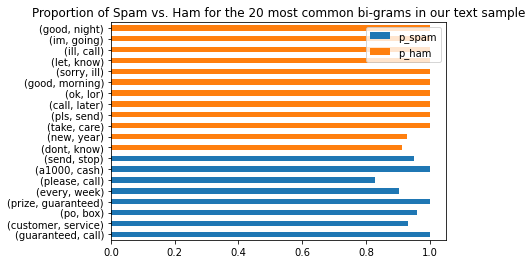

In [12]:
# visualize the percentage of the term in ham vs. spam

(word_counts.assign(p_spam = word_counts.spam/word_counts['all'], 
                   p_ham = word_counts.ham/word_counts['all'])
 .sort_values(by='all')[['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True)
)

plt.title("Proportion of Spam vs. Ham for the 20 most common bi-grams in our text sample")
plt.show()

#### Visualize w/Word Cloud

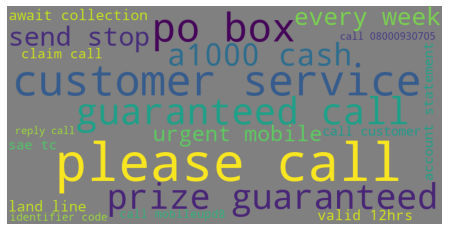

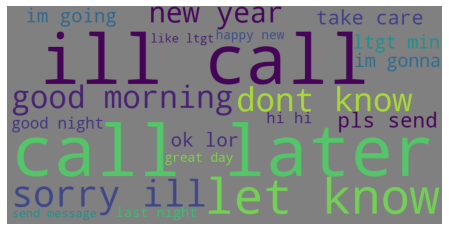

In [13]:
# spam bigram data
data = {k[0] + ' ' + k[1]: v for k, v in spam_bigrams.to_dict().items()}
img = WordCloud(background_color='grey', 
                width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

# ham bigram data
data = {k[0] + ' ' + k[1]: v for k, v in ham_bigrams.to_dict().items()}
img = WordCloud(background_color='grey', 
                width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()


#### Visualize Frequently Occuring Words:

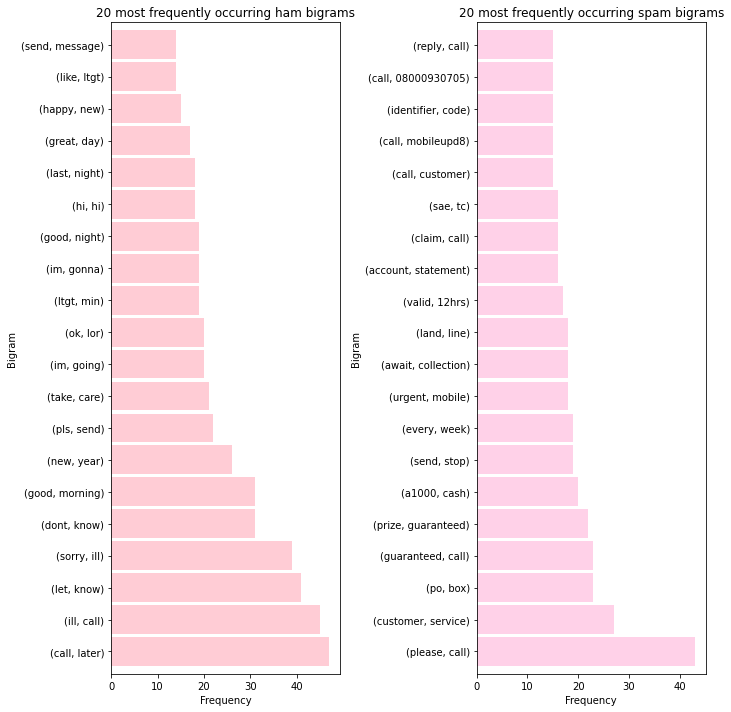

In [14]:
plt.subplot(121)
ham_bigrams.plot.barh(color='pink', width=.9, figsize=(10, 10), alpha=.8)
plt.title('20 most frequently occurring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')

plt.subplot(122)
spam_bigrams.plot.barh(color='hotpink', width=.9, figsize=(10, 10), alpha=.3)
plt.title('20 most frequently occurring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

#### -c. Is there any overlap in the bigrams for the spam data and the ham data?
        

`There does not appear to be any overlap in bigrams between the spam and ham data`

In [15]:
word_counts.sort_values(by='all', ascending=False).head(10)

,,all,ham,spam
please,call,52,0,43
call,later,47,47,0
ill,call,45,45,0
let,know,41,41,0
sorry,ill,39,39,0
dont,know,34,31,0
good,morning,31,31,0
customer,service,29,0,27
new,year,28,26,0
po,box,24,0,23


In [16]:
# if any word in spam are shared in ham

word_counts[word_counts.ham<5].sort_values(by='spam').tail(10)

,,all,ham,spam
urgent,mobile,0,0,18
land,line,0,0,18
send,stop,20,0,19
every,week,21,0,19
a1000,cash,20,0,20
prize,guaranteed,22,0,22
po,box,24,0,23
guaranteed,call,23,0,23
customer,service,29,0,27
please,call,52,0,43


#### -d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.
        

In [17]:
# Create trigrams

ham_trigrams = pd.Series(list(nltk.ngrams(ham_words.split(), 3))).value_counts().head(20)
spam_trigrams = pd.Series(list(nltk.ngrams(spam_words.split(), 3))).value_counts().head(20)
all_trigrams = pd.Series(list(nltk.ngrams(all_words.split(), 3))).value_counts().head(20)

In [18]:
# Count trigrams

word_counts = (pd.concat([all_trigrams, ham_trigrams, spam_trigrams], axis=1, sort=True)
               .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

,,,all,ham,spam
2003,account,statement,13,0,13
750,anytime,network,0,0,9
a2000,bonus,caller,0,0,10
anytime,network,min,11,0,11
bedroom,minute,ok,0,5,0


#### Visualize with horizontal bar chart:

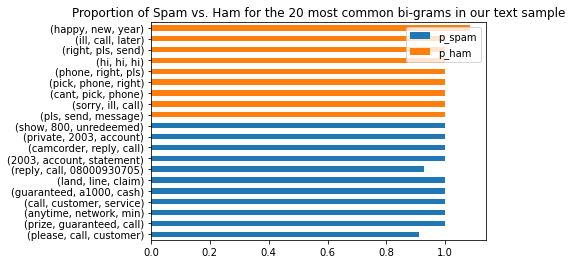

In [19]:
# visualize the percentage of the term in ham vs. spam

(word_counts.assign(p_spam = word_counts.spam/word_counts['all'], 
                   p_ham = word_counts.ham/word_counts['all'])
 .sort_values(by='all')[['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True)
)

plt.title("Proportion of Spam vs. Ham for the 20 most common bi-grams in our text sample")
plt.show()

#### Visualize with word cloud:

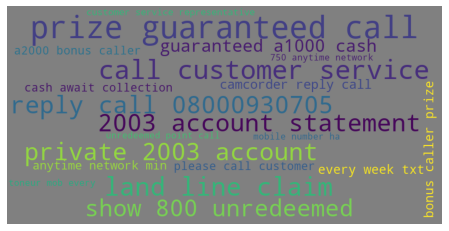

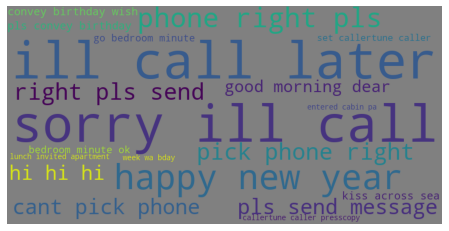

In [20]:
# spam bigram data
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in spam_trigrams.to_dict().items()}
img = WordCloud(background_color='grey', 
                width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

# ham bigram data
data =  {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in ham_trigrams.to_dict().items()}
img = WordCloud(background_color='grey', 
                width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Visualize Frequently Occuring Words:

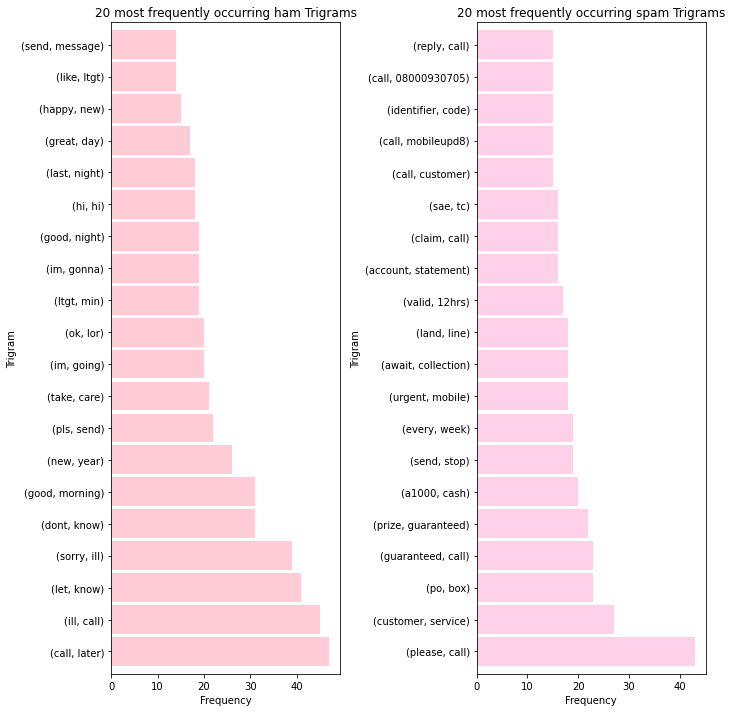

In [21]:
plt.subplot(121)
ham_bigrams.plot.barh(color='pink', width=.9, figsize=(10, 10), alpha=.8)
plt.title('20 most frequently occurring ham Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Frequency')

plt.subplot(122)
spam_bigrams.plot.barh(color='hotpink', width=.9, figsize=(10, 10), alpha=.3)
plt.title('20 most frequently occurring spam Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

**Takeaway:**

`1. Tri-grams are much more prevolent in spam then in ham`

***

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [22]:
# Using prepare file (prepare.py)

df = pd.read_json('big_blogs.json')
df = prepare.prep_article_data(df, 'content')
df.head()

,title,content,stemmed,lemmatized,clean
0,Codeup’s Data Science Career Accelerator is Here!,The rumors are true! The time has arrived. Cod...,he rumor are true he time ha arriv odeup ha of...,he rumor are true he time ha arrived odeup ha ...,rumor true time arrived odeup officially opene...
1,Data Science Myths,By Dimitri Antoniou and Maggie Giust\nData Sci...,y imitri ntoniou and aggi iust ata cienc ig at...,y imitri ntoniou and aggie iust ata cience ig ...,imitri ntoniou aggie iust ata cience ig ata ac...
2,Data Science VS Data Analytics: What’s The Dif...,"By Dimitri Antoniou\nA week ago, Codeup launch...",y imitri ntoniou week ago odeup launch our imm...,y imitri ntoniou week ago odeup launched our i...,imitri ntoniou week ago odeup launched immersi...
3,10 Tips to Crush It at the SA Tech Job Fair,SA Tech Job Fair\nThe third bi-annual San Anto...,ech ob air he third biannual an ntonio ech ob ...,ech ob air he third biannual an ntonio ech ob ...,ech ob air third biannual ntonio ech ob air ar...
4,Competitor Bootcamps Are Closing. Is the Model...,Competitor Bootcamps Are Closing. Is the Model...,ompetitor ootcamp re lose s the odel in anger ...,ompetitor ootcamps re losing s the odel in ang...,ompetitor ootcamps losing odel anger programmi...


## Better functions, need to re write prepare file

In [23]:
#using functions defined here

df = pd.read_json('big_blogs.json')
df['text_cleaned'] = df.content.apply(basic_clean)
df['text_tokenized'] = df.text_cleaned.apply(tokenize)
df['text_lemmatized'] = df.text_tokenized.apply(lemmatize)
df['text_filtered'] = df.text_lemmatized.apply(remove_stopwords)
# Add column with list of words
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
# Adds colum with lenght of word list
df['doc_length'] = [len(wordlist) for wordlist in df.words]
df.head()

,title,content,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,doc_length
0,Codeup’s Data Science Career Accelerator is Here!,The rumors are true! The time has arrived. Cod...,the rumors are true the time has arrived codeu...,the rumors are true the time has arrived codeu...,the rumor are true the time ha arrived codeup ...,rumor true time ha arrived codeup ha officiall...,"[rumor, true, time, ha, arrived, codeup, ha, o...",231
1,Data Science Myths,By Dimitri Antoniou and Maggie Giust\nData Sci...,by dimitri antoniou and maggie giust\ndata sci...,by dimitri antoniou and maggie giust\ndata sci...,by dimitri antoniou and maggie giust data scie...,dimitri antoniou maggie giust data science big...,"[dimitri, antoniou, maggie, giust, data, scien...",379
2,Data Science VS Data Analytics: What’s The Dif...,"By Dimitri Antoniou\nA week ago, Codeup launch...",by dimitri antoniou\na week ago codeup launche...,by dimitri antoniou\na week ago codeup launche...,by dimitri antoniou a week ago codeup launched...,dimitri antoniou week ago codeup launched imme...,"[dimitri, antoniou, week, ago, codeup, launche...",297
3,10 Tips to Crush It at the SA Tech Job Fair,SA Tech Job Fair\nThe third bi-annual San Anto...,sa tech job fair\nthe third biannual san anton...,sa tech job fair\nthe third biannual san anton...,sa tech job fair the third biannual san antoni...,sa tech job fair third biannual san antonio te...,"[sa, tech, job, fair, third, biannual, san, an...",392
4,Competitor Bootcamps Are Closing. Is the Model...,Competitor Bootcamps Are Closing. Is the Model...,competitor bootcamps are closing is the model ...,competitor bootcamps are closing is the model ...,competitor bootcamps are closing is the model ...,competitor bootcamps closing model danger prog...,"[competitor, bootcamps, closing, model, danger...",224


#### Create corpus of all posts

In [24]:
# move clean text to a string object, then remove all extra spaces or single letters
all_words = ' '.join(df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
type(all_words)

str

#### Explore Corpus

In [25]:
#Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

data        71
science     26
company     20
learning    20
job         14
dtype: int64

#### Word Counts:

In [26]:
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

,all
10,3
10th,1
11,1
12,1
13,2


`We can now use this data set to answer some interesting questions:`

   - Are there words that should be added to the stopword list?
   - Are there words that are significantly more likely to occur in spam than in ham?

In [27]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all
data,71
science,26
learning,20
company,20
job,14
machine,14
scientist,13
like,12
model,12
education,10


**Takeaway:**

`1. Most of the blog posts revolve around 'data', 'science', 'learning'.`   
`2. Looks like Codeup is pushing DS more then WebDev on Blog`   

***

### Visualize (Single Words):

#### Word Cloud:

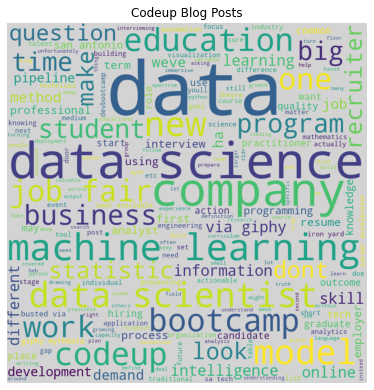

In [29]:
word_cloud = WordCloud(background_color='lightgray', 
                      height=800, width=800).generate(all_words)
plt.figure(figsize=(10,10))
axs = [plt.axes([.25, 1, .5, .5])]
axs[0].imshow(word_cloud)
axs[0].set_title('Codeup Blog Posts')
for ax in axs: ax.axis('off')

### Visualize (Bigrams):

In [31]:
# Create bigrams
all_bigrams = pd.Series(list(nltk.ngrams(all_words.split(), 2))).value_counts().head(20)

In [32]:
# Count bigrams
word_counts = (pd.concat([all_bigrams], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

,all
"(25, seat)",3
"(big, data)",3
"(big, education)",3
"(bootcamp, model)",4
"(busted, via)",4


#### Visualize with Wordcloud

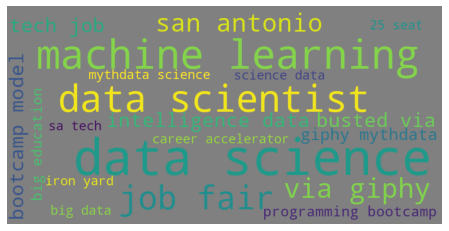

In [35]:
# spam bigram data
data = {k[0] + ' ' + k[1]: v for k, v in all_bigrams.to_dict().items()}
img = WordCloud(background_color='grey', 
                width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Visualize Frequenly Occuring Words

Text(0.5, 0, 'Frequency')

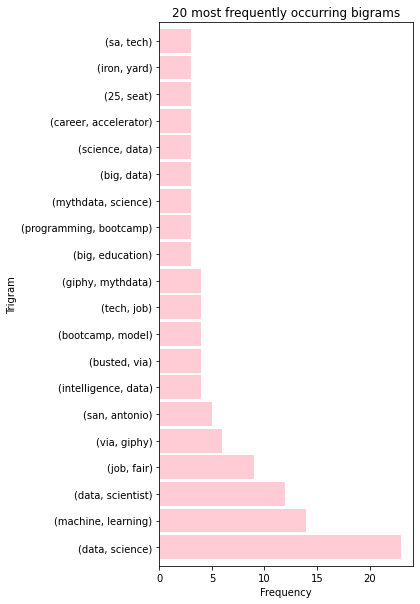

In [38]:
plt.subplot(121)
all_bigrams.plot.barh(color='pink', width=.9, figsize=(10, 10), alpha=.8)
plt.title('20 most frequently occurring bigrams')
plt.ylabel('Trigram')
plt.xlabel('Frequency')

**Takeaway:**   
`1. Need to modify corpus, to clump 'data science' and 'data scientist'`   
***

### Visualize (Trigrams):

### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.